In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from MFEA_lib.GA import population_init, factorial_cost, factorial_rank, skill_factor_best_task
from MFEA_lib.model.mfea import *
from MFEA_lib.model.utils import saveModel, loadModel, compareModel
from MFEA_lib.tasks.function import AbstractFunc
from MFEA_lib.operators import CrossOver, Mutation, Selection
from MFEA_lib.operators.CrossOver import SBX_CrossOver
from MFEA_lib.operators.Selection import ElitismSelection
from MFEA_lib.operators.Mutation import Polynomial_Mutation, NoMutation
from MFEA_lib.tasks.Benchmark import CEC17_benchmark, GECCO20_benchmark_50tasks


In [2]:
class cus_MFEA(AbstractModel):
    pass


In [3]:
class per_MFEA(AbstractModel):

    class battle_rmp:
        def __init__(self, idx_host: int, nb_tasks: int, lr):
            assert idx_host < nb_tasks
            self.idx_host = idx_host
            self.nb_tasks = nb_tasks
            # rmp without 0.5 of host
            self.rmp_not_host = np.ones((nb_tasks, ))/(2 * nb_tasks)
            self.lr = lr

        def get_rmp(self) -> np.ndarray:
            rmp_return = np.copy(self.rmp_not_host)

            rmp_return[self.idx_host] += 0.5
            
            return rmp_return

        def update_rmp(self, loc, delta):
            '''
            delta > 0
            '''
            for i in range(self.nb_tasks):
                if i != loc:
                    self.rmp_not_host[i] -= delta * self.lr
                    self.rmp_not_host = np.clip(self.rmp_not_host, 1/(self.nb_tasks * 8), 0.5)

            self.rmp_not_host[loc] += 0.5 - np.sum(self.rmp_not_host)
        
            return self.get_rmp()
    
    def compile(self, cross_over = CrossOver.SBX_CrossOver(), mutation=  Mutation.Polynomial_Mutation(), selection= Selection.ElitismSelection()):
        super().compile(cross_over, mutation, selection)

    def render_rmp(self, shape = None, title = None, figsize = None, dpi = 200, step = 1, get_host = False):
        if figsize is None:
            figsize = (30, 30)
        if title is None:
            title = self.__class__.__name__ + 'get_host = ' + str(get_host)
        if shape is None:
            shape = (int(np.ceil(len(self.tasks) / 3)), 3)
        else:
            assert shape[0] * shape[1] >= len(self.tasks)
        fig = plt.figure(figsize= figsize, dpi = dpi)
        fig.suptitle(title, size = 15)
        fig.set_facecolor("white")

        if not get_host:
            his_rmp = np.copy(self.history_rmp)
            for i in range(len(self.tasks)):
                his_rmp[:, i, i] -= 0.5
            y_lim = (-0.05, 0.55)
        else:
            his_rmp = np.copy(self.history_rmp)
            y_lim = (-0.1, 1.1)

        for i in range (len(self.tasks)):
            plt.subplot(shape[0], shape[1], i + 1)
            plt.stackplot(
                np.append(np.arange(0, len(his_rmp), step), np.array([len(his_rmp) - 1])),
                [his_rmp[
                    np.append(np.arange(0, len(his_rmp), step), np.array([len(his_rmp) - 1])), 
                    i, t] for t in range(len(self.tasks))],
                labels = ['task' + str(i + 1) for i in range(len(self.tasks))]
            )

            plt.legend()
            plt.title('task ' + str( i + 1))
            plt.xlabel("Epoch")
            plt.ylabel("M_rmp")
            plt.ylim(bottom = y_lim[0], top = y_lim[1])
        return fig

    def findParent(self, idx_parents, pop_fcost, type = None):
        if type == 'intra':
            idx_p1, idx_p2 = np.random.choice(idx_parents, size= 2, replace= False)
            return (idx_p1, idx_p2)[np.argmin([pop_fcost[idx_p1], pop_fcost[idx_p2]])]
        elif type == 'inter' or 'inter1skf':
            idx = np.random.choice(idx_parents)
            return idx
        else:
            raise ValueError()

    def fit(self, tasks: list[AbstractFunc], num_epochs, num_inds_each_task=100, nb_inds_min = None, lr = 0.01, nb_epochs_stop = 10,
                evaluate_initial_skillFactor=True, range_init_pop= [0, 1]) -> tuple[list[np.ndarray], np.ndarray]:
                # LSA or SA
        if nb_inds_min is not None:
            assert num_inds_each_task >= nb_inds_min
        else:
            nb_inds_min = num_inds_each_task
            
        self.tasks = tasks

        # initial history of factorial cost -> for render
        self.history_cost = np.empty((0, len(tasks)), np.float) 
        self.history_rmp = []

        # dim of Unified search space
        dim_uss = max([t.dim for t in tasks])

        # initial population
        inf, sup = range_init_pop
        population, skill_factor_arr = population_init(
            N = num_inds_each_task,
            num_tasks= len(tasks),
            d = dim_uss,
            min_val= inf,
            max_val= sup
        )

        if evaluate_initial_skillFactor:
            skill_factor_arr = skill_factor_best_task(population, tasks)
        pop_fcost = factorial_cost(population, skill_factor_arr, tasks)
        pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))

        # SA params:
        MAXEVALS = num_epochs * num_inds_each_task * len(tasks)
        eval_k = np.zeros(len(tasks))
        epoch = 0

        # NOTE per params:
        # prob choose first parent
        p_choose_father = np.array([1/len(tasks) for i in range(len(tasks))])
        # count_eval_stop: nums evals not decrease factorial cost
        # maxcount_es: max of count_eval_stop
        # if count_eval[i] == maxcount_es: p_choose_father[i] == 0
        count_eval_stop = [0] * len(tasks)
        maxcount_es = nb_epochs_stop * num_inds_each_task

        # Initial success history memory M_rmp
        M_rmp = [self.battle_rmp(i, len(tasks), lr) for i in range(len(tasks))]

        # save history_cost
        self.history_cost = np.append(self.history_cost, 
            [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
            axis = 0
        )
        self.history_rmp.append([M_rmp[i].get_rmp() for i in range(len(tasks))])
        epoch = 1

        while np.sum(eval_k) <= MAXEVALS:

            # initial offspring of generation
            offspring = np.empty((0, dim_uss))
            offspring_skill_factor = np.empty((0, ), np.int)
            offspring_fcost = np.empty((0, ))

            while len(offspring) < len(population):
                if np.sum(eval_k) >= epoch * num_inds_each_task * len(tasks):
                    #save history
                    self.history_cost = np.append(self.history_cost, 
                        [[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))]], 
                        axis = 0
                    ) 
                    self.history_rmp.append([M_rmp[i].get_rmp() for i in range(len(tasks))])

                    #print
                    sys.stdout.write('\r')
                    sys.stdout.write('Epoch {}, [%-10s] %3d%% ,pop_size: {}, func_val: {}'
                        .format(epoch, len(population),[np.min(pop_fcost[np.where(skill_factor_arr == idx)[0]]) for idx in range (len(tasks))])
                        % ('=' * np.int((np.sum(eval_k) + 1) // (MAXEVALS // 10)) + '>' , (np.sum(eval_k) + 1) * 100 // MAXEVALS)
                        )
                    sys.stdout.flush()

                    epoch += 1
                
                # choose father
                skf_pa = np.random.choice(np.arange(len(tasks)), p = p_choose_father)

                # random with prob rmp
                # get rmp
                rmp = M_rmp[skf_pa].get_rmp()

                # pb with rmp
                skf_pb = np.random.choice(np.arange(len(tasks)), p = rmp)
                if skf_pb == skf_pa: type_crossover = 'intra'
                else: type_crossover = 'inter1skf'

                #find parent
                idx_pa = self.findParent(np.where(skill_factor_arr == skf_pa)[0], pop_fcost, type = type_crossover)
                idx_pb = self.findParent(np.where(skill_factor_arr == skf_pb)[0], pop_fcost, type = type_crossover)

                pa, pb = population[idx_pa], population[idx_pb]

                oa, ob = self.cross_over(pa, pb, type_crossover, 0.1)
                oa, ob = self.mutation(oa), self.mutation(ob)
                skf_oa, skf_ob = skf_pa, skf_pa

                # Evaluate oa, ob
                fcost_oa, fcost_ob = tasks[skf_oa].func(oa), tasks[skf_ob].func(ob)

                # Calculate the maximum improvement percetage
                if type_crossover == 'intra':
                    Delta = max(0, 
                            (min(pop_fcost[idx_pa], pop_fcost[idx_pb]) - fcost_oa)/(min(pop_fcost[idx_pa], pop_fcost[idx_pb]) + 1e-100),
                            (min(pop_fcost[idx_pa], pop_fcost[idx_pb]) - fcost_ob)/(min(pop_fcost[idx_pa], pop_fcost[idx_pb]) + 1e-100)
                    )
                    Delta = np.random.choice([0, Delta], p = [0.5/rmp[skf_pb], 1 - 0.5/rmp[skf_pb]])
                else:
                    Delta = max(0, 
                        (pop_fcost[idx_pa] - fcost_oa)/(pop_fcost[idx_pa] + 1e-100),
                        (pop_fcost[idx_pa] - fcost_ob)/(pop_fcost[idx_pa] + 1e-100)
                    )

                if Delta > 0:
                    # update M_rmp
                    M_rmp[skf_pa].update_rmp(skf_pb, Delta)
                    count_eval_stop[skf_pa] = 0
                else:
                    # count eval not decrease
                    count_eval_stop[skf_pa] += 1
                    if count_eval_stop[skf_pa] == maxcount_es:
                        p_choose_father[skf_pa] = 0
                        idx_not_stop = np.where(p_choose_father > 0)[0]
                        p_choose_father[idx_not_stop] = 1/len(idx_not_stop)
            
                eval_k[skf_oa] += 1
                eval_k[skf_ob] += 1
                offspring = np.append(offspring, [oa, ob], axis = 0)
                offspring_skill_factor = np.append(offspring_skill_factor, [skf_oa, skf_ob], axis = 0)
                offspring_fcost = np.append(offspring_fcost, [fcost_oa, fcost_ob], axis = 0)

            # merge
            population = np.append(population, offspring, axis = 0)
            skill_factor_arr = np.append(skill_factor_arr, offspring_skill_factor, axis = 0)
            pop_fcost = np.append(pop_fcost, offspring_fcost, axis = 0)

            # selection
            pop_fitness = 1/factorial_rank(pop_fcost, skill_factor_arr, len(tasks))
            nb_inds_tasks = [int(min((nb_inds_min - num_inds_each_task)/num_epochs * epoch + num_inds_each_task, num_inds_each_task))]*len(tasks)
            idx = self.selection(skill_factor_arr, pop_fitness, nb_inds_tasks= nb_inds_tasks)

            population = population[idx]
            skill_factor_arr = skill_factor_arr[idx]
            pop_fcost = pop_fcost[idx]

        #solve
        sol_idx = [np.argmin(pop_fcost[np.where(skill_factor_arr == idx)]) for idx in range (len(tasks))]
        self.solve = [task.decode(population[np.where(skill_factor_arr == idx)][sol_idx[idx]]) for idx, task in enumerate(tasks)]

        return self.solve, self.history_cost



In [4]:
cec17_10tasks_fixed = CEC17_benchmark.get_10tasks_benchmark(fix = True)


In [6]:
per_model = per_MFEA()

per_model.compile(
    cross_over= SBX_CrossOver(nc = 2),
    mutation= NoMutation(),
    # mutation= Polynomial_Mutation(nm = 5),
    selection= ElitismSelection()
)

sol, his = per_model.fit(tasks = cec17_10tasks_fixed, num_epochs= 1000, num_inds_each_task= 100, nb_inds_min= 100, lr = .01, 
                nb_epochs_stop = 10,
                evaluate_initial_skillFactor= True)
                
saveModel(per_model, "./RESULTS/cec17fixed_per_MFEA.mso")

Epoch 526, [=====>    ]  52% ,pop_size: 1000, func_val: [0.0008559871139551354, 0.00014873281210548052, 9.470689635029461e-07, 8.195399914256996e-11, 0.11157690326990143, 0.00403107499684241, 0.02608653847853759, 0.04382337865899899, 1.0636307051448135e-05, 35.51448626798873]3]]

KeyboardInterrupt: 

In [ ]:
model1 = loadModel("./RESULTS/cec17fixed_mfea1.mso")

base_model = loadModel("./RESULTS/cec17fixed_mfeabase.mso")

sa_model = loadModel("./RESULTS/cec17fixed_sa_mfea.mso")

lsa_model = loadModel("./RESULTS/cec17fixed_lsa_mfea.mso")

cus_model:cus_MFEA = loadModel("./RESULTS/cec17fixed_cusMFEA.mso")

cus_Lmodel:cus_MFEA = loadModel("./RESULTS/cec17fixed_cusLMFEA.mso")

per_model:per_MFEA = loadModel("./RESULTS/cec17fixed_per_MFEA.mso")

# per_Lmodel:per_MFEA = loadModel("./RESULTS/cec17fixed_per_LMFEA.mso")

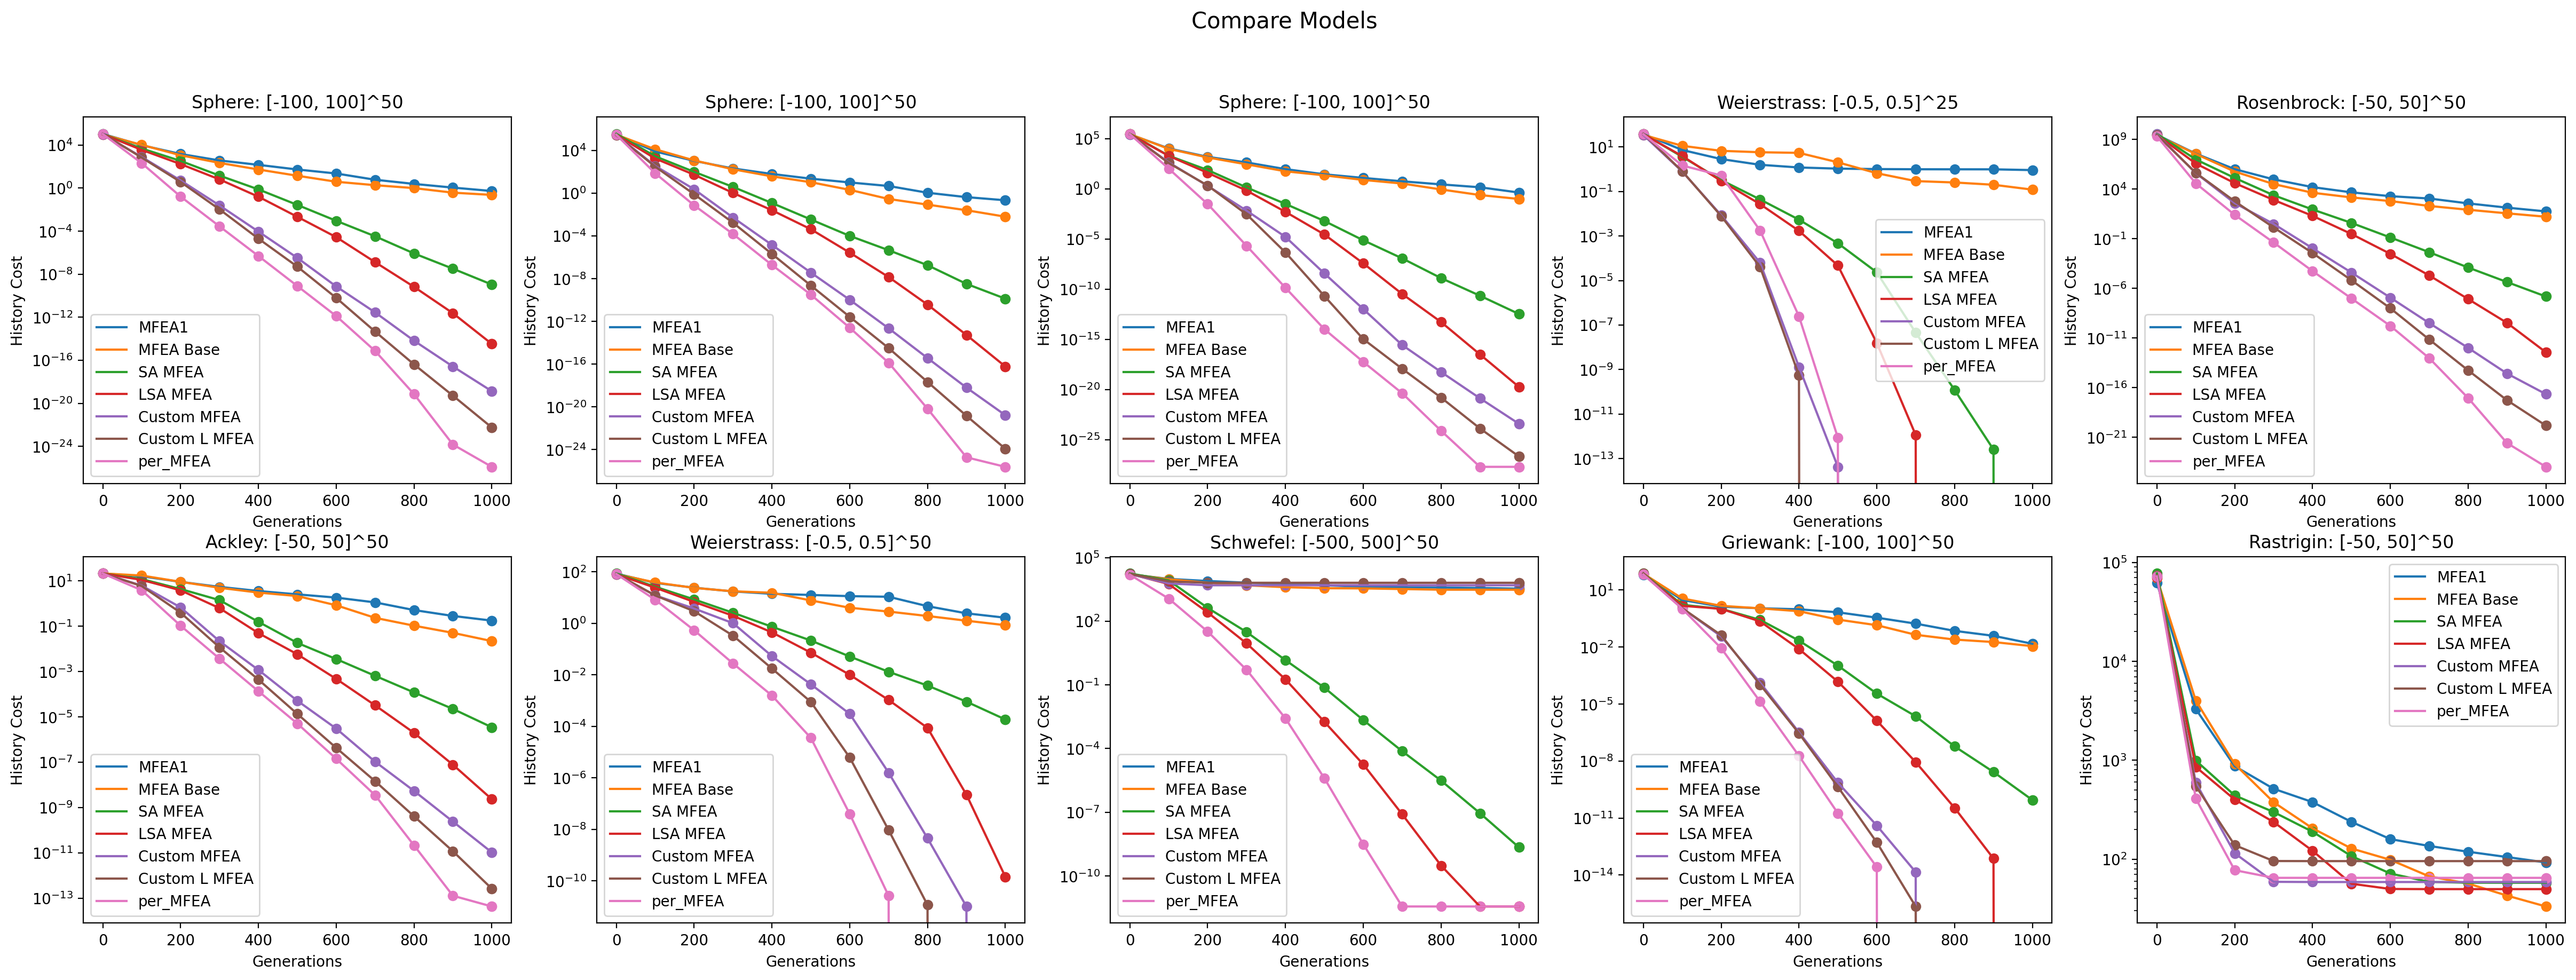

In [ ]:
compareModel(
    models= [model1, base_model, sa_model, lsa_model, cus_model, cus_Lmodel, per_model],
    label_legend=  ["MFEA1", "MFEA Base", "SA MFEA", "LSA MFEA", "Custom MFEA", "Custom L MFEA", "per_MFEA"],
    tasks= cec17_10tasks_fixed,
    shape= (2, 5),
    step= 100,
    yscale= 'log'
)
print()

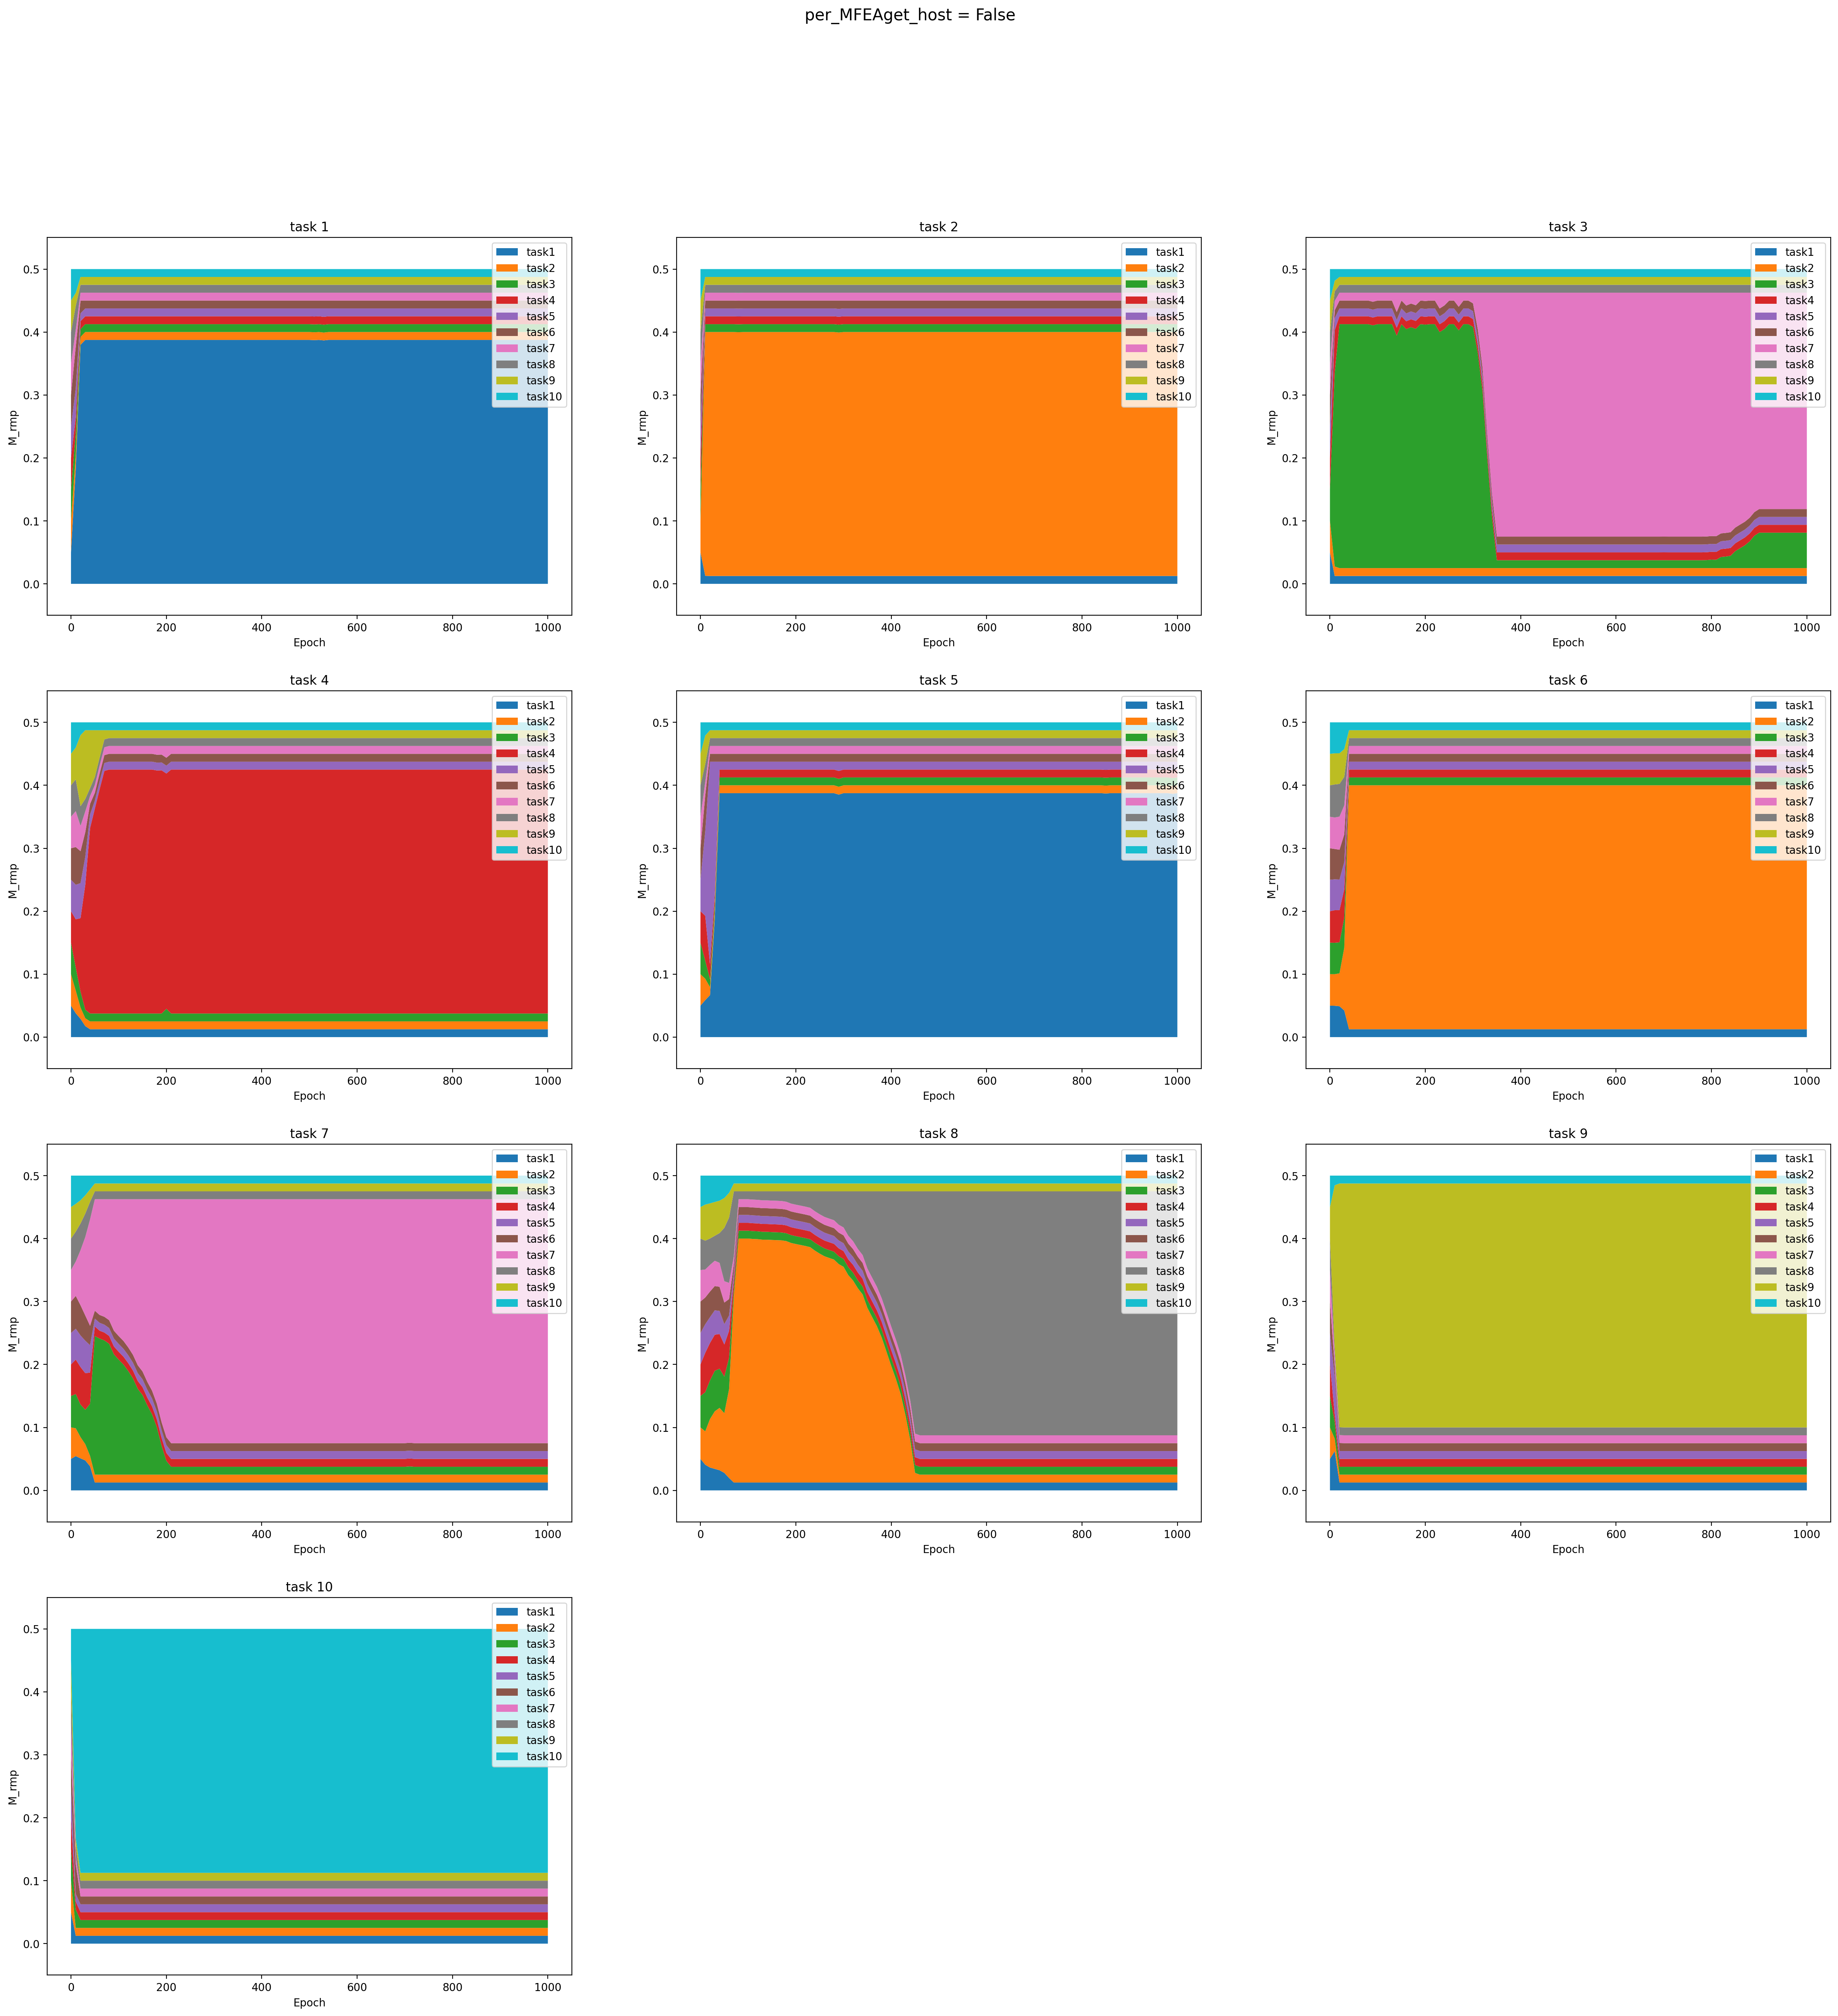

In [ ]:
per_model.render_rmp(step = 10, get_host= False)
print()

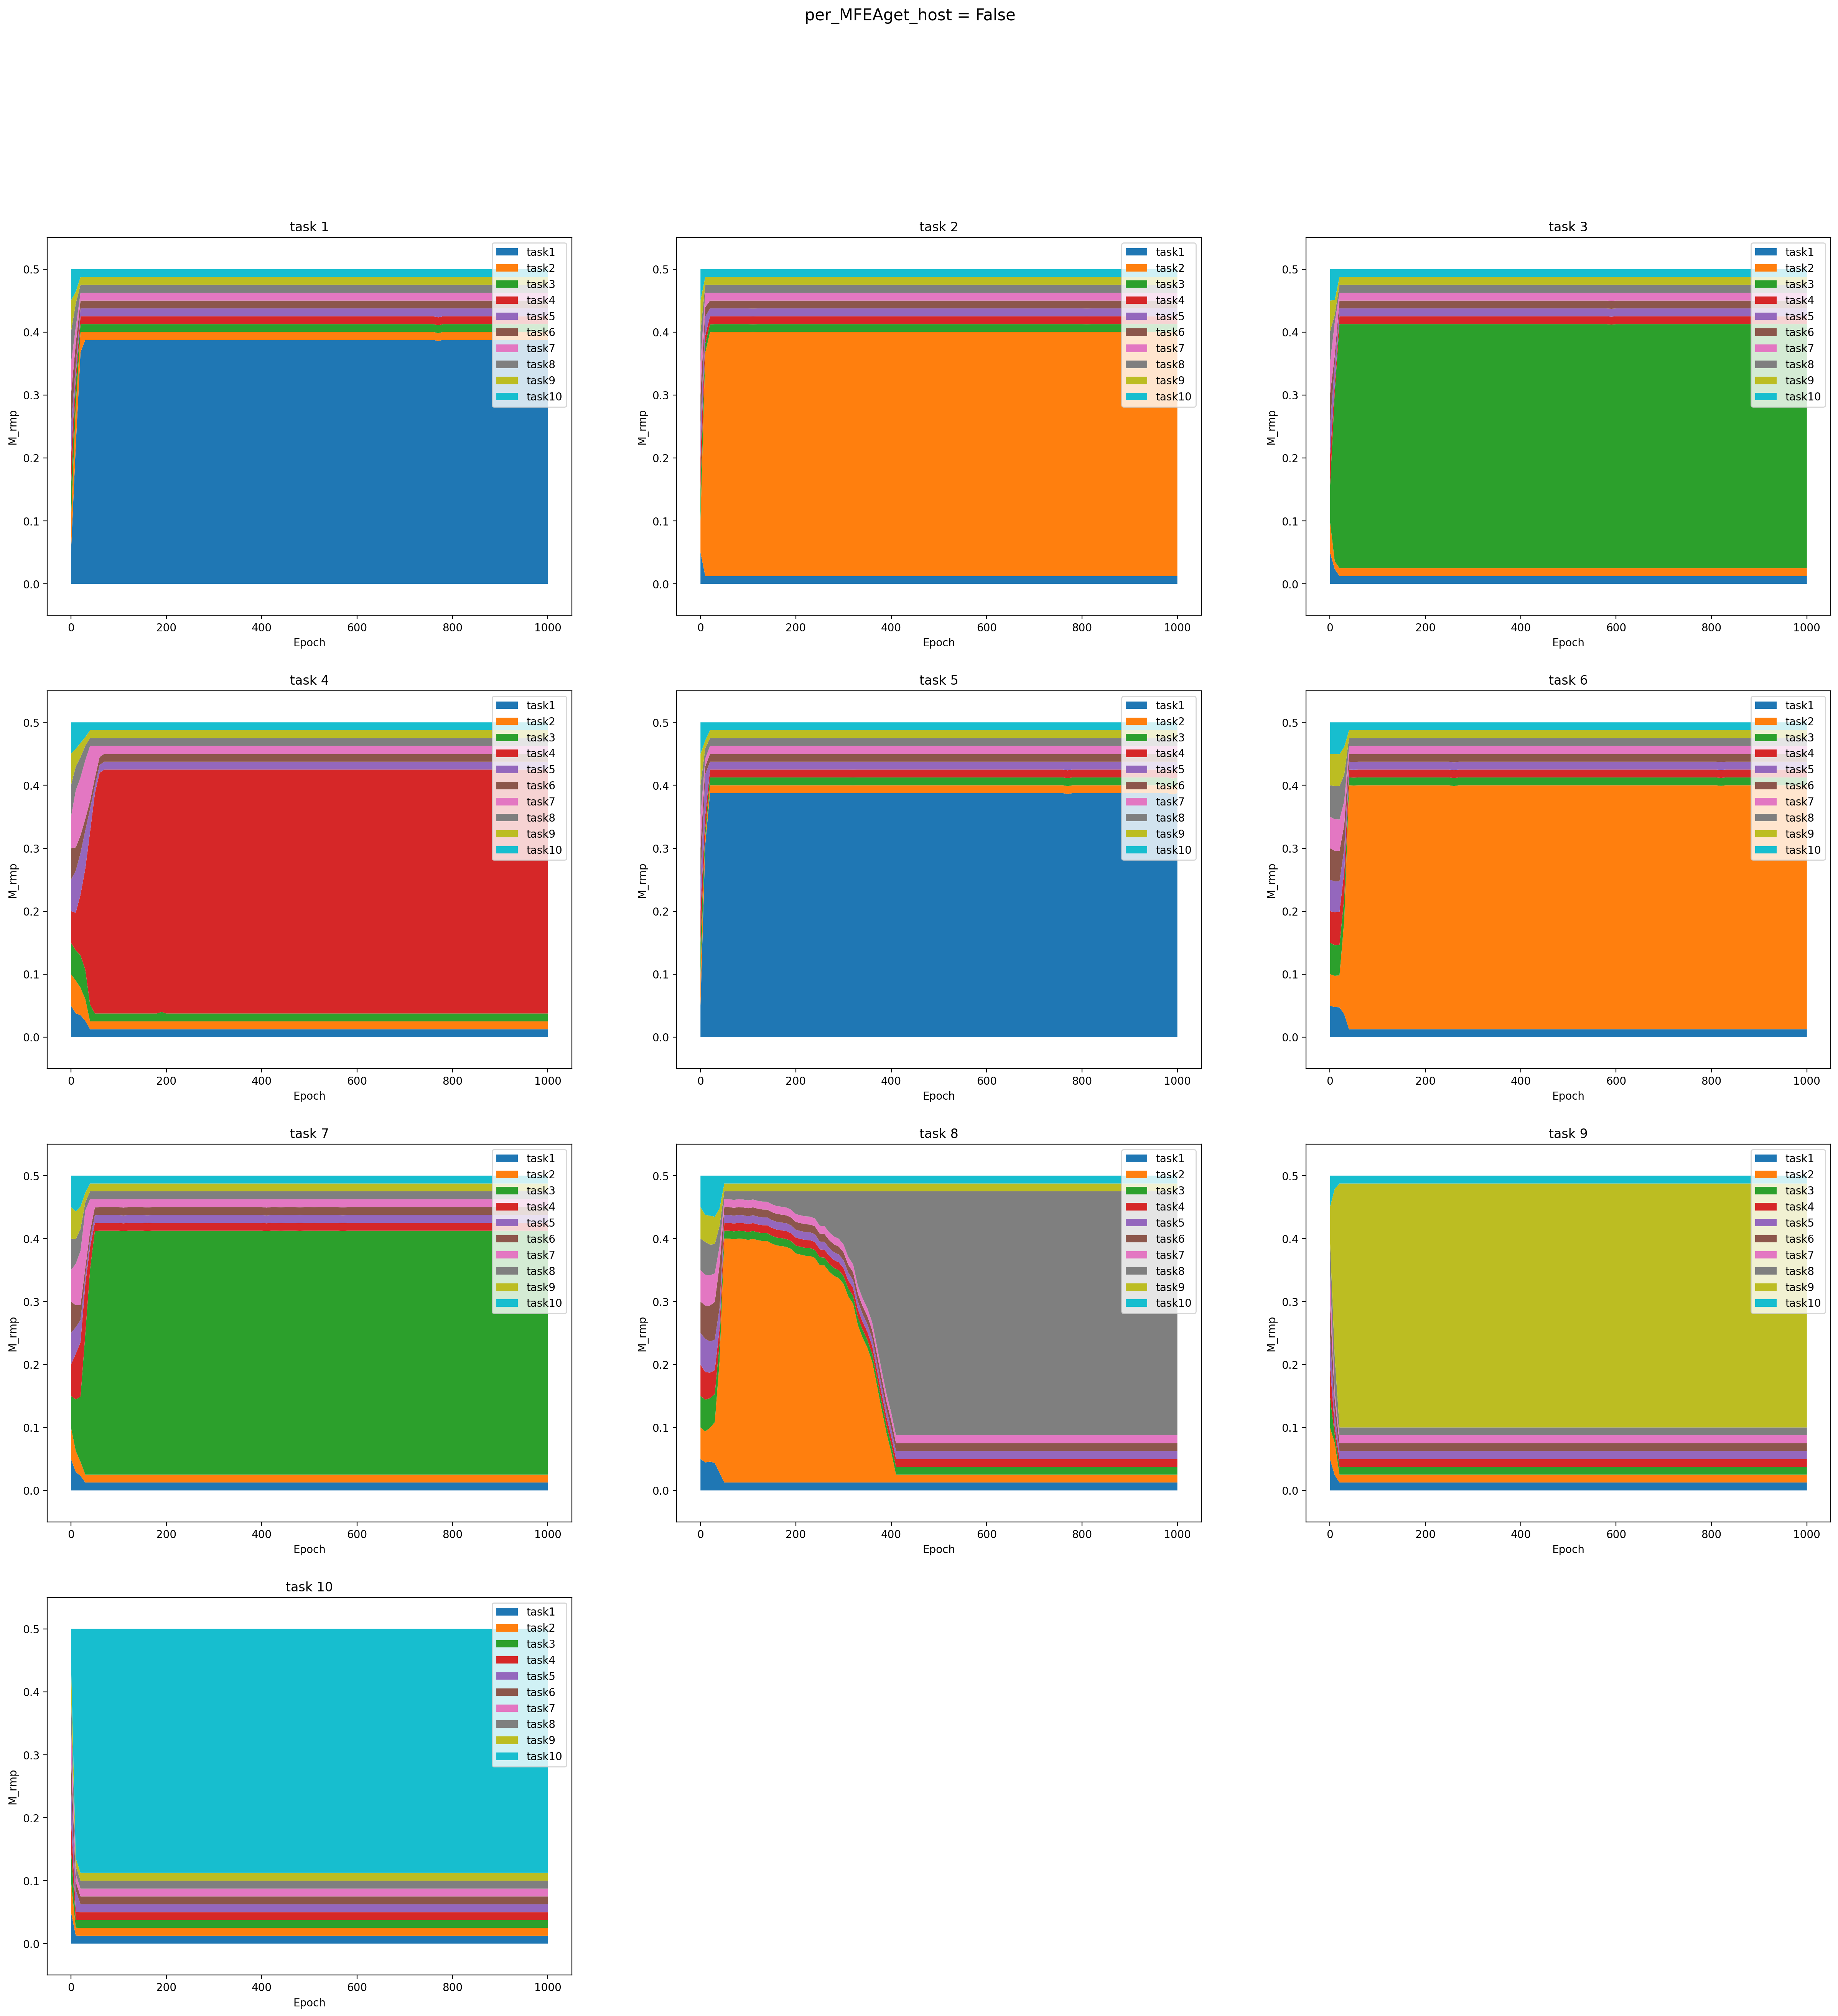

In [ ]:
per_Lmodel.render_rmp(step = 10, get_host= False)
print()